In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import sys
import os

# Importing my custom classes
sys.path.append(os.path.abspath(os.path.join('..')))
from src.regression import MyLinearRegression

# 1. Load Data
insurance_dataset = pd.read_csv(os.path.join('..', 'data', 'raw', 'insurance.csv'))

# 2. Feature Engineering (Adding new feature: "Smoker * BMI" because we saw in EDA that it was important.)
print(f"Original Dataset Shape: {insurance_dataset.shape}")
insurance_dataset['bmi_smoker_interaction'] = insurance_dataset['bmi'] * insurance_dataset['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
print(f"New Dataset Shape: {insurance_dataset.shape}")

# 3. Define X (Features) and y (Target)
X = insurance_dataset.drop(columns=['charges'])
y = insurance_dataset['charges']

# 4. Split Data (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Split Successfully.")

Original Dataset Shape: (1338, 7)
New Dataset Shape: (1338, 8)
Data Split Successfully.


In [2]:
# Identify columns
numeric_features = ['age', 'bmi', 'children', 'bmi_smoker_interaction']
categorical_features = ['sex', 'smoker', 'region']

# Create a Transformer
# StandardScaler: Squashes numbers to mean=0, std=1 (Prevents Exploding Gradient!)
# OneHotEncoder: Converts 'southwest' to [0, 0, 0, 1]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Fit and Transform
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Convert y to numpy array for our custom class
y_train_np = y_train.values
y_test_np = y_test.values

print(f"Original Shape: {X_train_raw.shape}")
print(f"Transformed Shape: {X_train.shape}")
# Note: Shape increased because OneHotEncoder added columns

Original Shape: (1070, 7)
Transformed Shape: (1070, 9)


Training custom model...
Iteration 0: Cost 322451733.1842413
Iteration 1000: Cost 25585858.68590517
My Model MSE: 21,337,326.49
My Model R2 Score: 0.8626


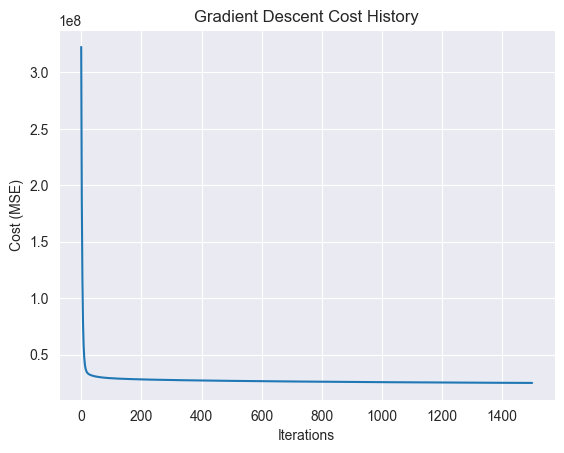

In [3]:
# Initialize your model
my_lr = MyLinearRegression(learning_rate=0.1, iterations=1500)

# Train
print("Training custom model...")
my_lr.fit(X_train, y_train_np)

# Predict
y_pred_my = my_lr.predict(X_test)

# Evaluate
mse_my = mean_squared_error(y_test_np, y_pred_my)
r2_my = r2_score(y_test_np, y_pred_my)

print(f"My Model MSE: {mse_my:,.2f}")
print(f"My Model R2 Score: {r2_my:.4f}")

# Plot the Cost History (Proof of Convergence)
plt.plot(my_lr.cost_history)
plt.title("Gradient Descent Cost History")
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.show()

In [4]:
# Train Sklearn
sk_lr = LinearRegression()
sk_lr.fit(X_train, y_train_np)
y_pred_sk = sk_lr.predict(X_test)

r2_sk = r2_score(y_test_np, y_pred_sk)

print(f"Sklearn R2 Score: {r2_sk:.4f}")
print(f"My R2 Score: {r2_my:.4f}")

if abs(r2_sk - r2_my) < 0.01:
    print("✅ Great job! Your custom implementation matches Scikit-Learn.")
else:
    print("⚠️ Slight difference. Check iteration count.")

Sklearn R2 Score: 0.8653
My R2 Score: 0.8626
✅ Great job! Your custom implementation matches Scikit-Learn.


In [5]:
from sklearn.preprocessing import PolynomialFeatures

# Create Polynomial Features (Degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Ridge Regression (Regularization prevents overfitting)
poly_model = Ridge(alpha=1.0)
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression (Degree 2) R2 Score: {r2_poly:.4f}")
print(f"Improvement over Linear: {r2_poly - r2_sk:.4f}")

Polynomial Regression (Degree 2) R2 Score: 0.8649
Improvement over Linear: -0.0004
